# LSTMs forecast with considering feature selection (1-1, Multi-1, Multi-Multi)

### 1) Prepare Dataset
　　－　Imputation dataset (from the gap filling result by '202105_Fill_gap_with_LRTC-TNN_all para-include_tempre.ipynb'  
　　－　3 buoys '2010-01-02 00:00:00' - '2019-12-30 23:30:00' with no NaN value, totally 175200 rows x 21 columns  
　　－　Degree transfer to sin & cos which can be reversed back to degree
### 2) Model Variables
　　－　taget_feature_FS, target_feature, n_past, n_future
### 3) Feature Selection (ElasticNetCV)
　　－　Reasons of choosing ElasticNetCV see the Jupyter Notebook '202105_Feature_Selection_Experiments.ipynb'
### 4) Generate training dataset (MinMax Normalization)
　　－　Train on table[:6000], test on table[6000:7200]
### 5) Generate Model
　　－　**No feature selection LSTM 1-to-1:** build_model_LSTM_1_1buoy(train, n_past, n_future, FS_order)  
　　－　**No feature selection LSTM all-to-1:** build_model_LSTM_1buoy(train, n_past, n_future, FS_order)  
　　－　<font color='red'>**LSTM with feature selection: build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order)**</font>   
　　－　**Seq2Seq:** build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order)  
　　－　**2StackedSeq2Seq:** build_model_2StackedLSTM(train, n_past, n_future, FS_order)  
　　－　**LSTM Dirp transformation only:** build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order)  
　　－　**Conditional LSTM considering ERA5:** build_model_ConditionLSTM_FS_1buoy(train, train_condition, n_past, n_future, FS_order)  
  -  Using AutoEncoder to realize dimensionality reduction: 5x5x2 => 5 => train_condition
      
### 6) Evaluate prediction
      


### General Conclusions:　
　　1) Feature selection can improve the accuracy and efficiency of forecast  
　　2) LSTM performs equivalent to Seq2Seq and 2-stacked-Seq2Seq with same layer number  
　　3) Dirp transformation to sin cos can get equivalent accuracy to forecast on degree. But it has a drawback that sometimes the regressive cos_x might get values less than -1 which makes it invalid. When updating the transfer function, the prediction accuracy decreases. Therefore, Dirp transformation in the sin & cos way is not necessary.  

In [1]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import pydot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Input, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Adam,Nadam
from tensorflow.keras import initializers
from sklearn.model_selection import KFold,GroupKFold

In [3]:
import os
os.environ["PATH"] += ";C:/Program Files (x86)/Graphviz2.38/bin"

In [4]:
import keras
print(keras.__version__)

2.5.0


In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import datetime
from sklearn.preprocessing import MinMaxScaler

In [6]:
import pickle
def save(fname, data, protocol=3):
    with open(fname, "wb") as f:
        pickle.dump(data, f, protocol)

def load(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

In [7]:
def cal_RMSE(origin, pred):
    mse = np.average((pred-origin)**2)
    rmse = np.sqrt(mse)

    return rmse

# def cal_MAPE(origin, pred):
#     from sklearn.metrics import mean_absolute_percentage_error as MAPE
#     return MAPE(origin, pred)

# 1) Prepare Dataset

In [257]:
table = load('Fill_Gap/Imputed_Measurement').resample('H').mean()
table.columns = ['1Wave Height (m)', '1Max Wave Height (m)', '1Tpeak (s)', '1Tz (s)',
       '1Peak Direction (degrees)', '1Spread (degrees)', '1Sea Temp (C)',
       '2Wave Height (m)', '2Max Wave Height (m)', '2Tpeak (s)', '2Tz (s)',
       '2Peak Direction (degrees)', '2Spread (degrees)', '2Sea Temp (C)',
       '3Wave Height (m)', '3Max Wave Height (m)', '3Tpeak (s)', '3Tz (s)',
       '3Peak Direction (degrees)', '3Spread (degrees)', '3Sea Temp (C)']
table

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,2Peak Direction (degrees),2Spread (degrees),2Sea Temp (C),3Wave Height (m),3Max Wave Height (m),3Tpeak (s),3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C)
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.390,0.560,10.80,6.55,187.5,13.0,8.15,0.550,0.780,12.20,...,204.5,17.0,9.05,0.530,0.865,7.65,4.05,299.5,34.5,9.05
2010-01-02 01:00:00,0.380,0.570,12.15,6.90,184.0,10.5,8.15,0.515,0.825,11.80,...,209.0,16.5,9.00,0.545,0.770,7.20,4.15,303.0,40.0,9.00
2010-01-02 02:00:00,0.370,0.525,10.80,7.10,189.0,12.0,8.30,0.465,0.690,11.50,...,212.0,16.5,9.00,0.590,0.950,10.25,4.20,280.0,27.0,8.85
2010-01-02 03:00:00,0.350,0.555,11.10,5.75,190.0,20.5,8.85,0.480,0.780,10.80,...,219.0,13.5,8.95,0.705,1.260,4.40,3.75,332.0,44.0,8.80
2010-01-02 04:00:00,0.360,0.550,10.50,6.90,187.0,25.0,8.90,0.480,0.720,10.55,...,216.0,17.0,8.50,0.840,1.375,4.60,3.50,337.5,47.0,9.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,0.850,1.495,5.05,4.30,188.0,20.5,10.60,0.880,1.375,11.15,...,210.5,15.0,10.70,1.460,2.230,11.80,6.40,266.0,48.5,10.60
2019-12-30 20:00:00,0.805,1.145,5.15,4.35,188.0,18.5,10.60,0.920,1.285,10.80,...,212.5,12.5,10.70,1.425,2.070,11.45,6.65,260.5,41.5,10.60
2019-12-30 21:00:00,0.745,1.225,5.15,4.30,185.0,19.0,10.55,0.905,1.165,10.55,...,206.0,14.0,10.85,1.280,2.020,11.80,6.45,282.0,36.0,10.60


In [9]:
len(table.dropna()) # Imputation to Non-NaN

87600

In [1706]:
# Due to gap filling error, negligible numbers of Dirp are above 360. 
# table[table['1Peak Direction (degrees)']>360] 

#### Degree transfer
According to experiments, the prediction accuracy of Dirp is not satisfied greatly due to the incontinous of degree from 0~360. Here, I tried a new method to transfer degree to sin & cos, and they can be reversed to degree after prediction.

In [2047]:
# Get degree from sin & cos function
from interval import Interval
def return_degree(sin_x, cos_x): 
    if (1 >= sin_x >= 0) & (1 >= cos_x > 0):
        return np.arcsin(sin_x)*180/np.pi
    if (1 >= sin_x > 0) & (-1<= cos_x <= 0):
        return np.arccos(cos_x)*180/np.pi
    elif ((cos_x in Interval(-1,1)) & (sin_x in Interval(-1,1)))==True:
        return 360-np.arccos(cos_x)*180/np.pi
    elif (sin_x in Interval(-1,1))==True:
        return 360+np.arcsin(sin_x)*180/np.pi
    elif (cos_x in Interval(-1,1))==True:
        return 360-np.arccos(cos_x)*180/np.pi
    else:
        return 0

# Example
degree_test = 270 # Any degree transfer to within [0, 360]
a,b = np.sin(degree_test*np.pi/180), np.cos(degree_test*np.pi/180)
return_degree(a,b)

270.0

In [2048]:
# Transfer degree to sin & cos
for i in range(1,4):
    locals()['Dirp'+str(i)+'_sin'] = np.array(np.sin(table[str(i)+'Peak Direction (degrees)']*np.pi/180))
    locals()['Dirp'+str(i)+'_sin'][(locals()['Dirp'+str(i)+'_sin']<1e-10) & (locals()['Dirp'+str(i)+'_sin']>0)]=0 # Turn small number to 0
    locals()['Dirp'+str(i)+'_cos'] = np.array(np.cos(table[str(i)+'Peak Direction (degrees)']*np.pi/180))
    locals()['Dirp'+str(i)+'_cos'][(locals()['Dirp'+str(i)+'_cos']<1e-10) & (locals()['Dirp'+str(i)+'_cos']>0)]=0

# Reverse sin & cos to degree
Dirp1_reverse = np.array([return_degree(Dirp1_sin[j],Dirp1_cos[j]) for j in range(len(table))])
Dirp2_reverse = np.array([return_degree(Dirp2_sin[j],Dirp2_cos[j]) for j in range(len(table))])
Dirp3_reverse = np.array([return_degree(Dirp3_sin[j],Dirp3_cos[j]) for j in range(len(table))])

In [2015]:
for i in range(1,4):
    table['Dirp'+str(i)+'_sin'] = locals()['Dirp'+str(i)+'_sin']
    table['Dirp'+str(i)+'_cos'] = locals()['Dirp'+str(i)+'_cos']

In [2016]:
table.head()

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C),Dirp1_sin,Dirp1_cos,Dirp2_sin,Dirp2_cos,Dirp3_sin,Dirp3_cos
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.41,0.53,10.5,6.8,188.0,16.0,8.1,0.58,0.77,13.3,...,4.0,283.0,27.0,9.0,-0.139173,-0.990268,-0.358368,-0.933580,-0.974370,0.224951
2010-01-02 00:30:00,0.37,0.59,11.1,6.3,187.0,10.0,8.2,0.52,0.79,11.1,...,4.1,316.0,42.0,9.1,-0.121869,-0.992546,-0.469472,-0.882948,-0.694658,0.719340
2010-01-02 01:00:00,0.38,0.55,12.5,6.8,184.0,9.0,8.1,0.52,0.84,11.1,...,4.2,280.0,31.0,9.0,-0.069756,-0.997564,-0.573576,-0.819152,-0.984808,0.173648
2010-01-02 01:30:00,0.38,0.59,11.8,7.0,184.0,12.0,8.2,0.51,0.81,12.5,...,4.1,326.0,49.0,9.0,-0.069756,-0.997564,-0.390731,-0.920505,-0.559193,0.829038
2010-01-02 02:00:00,0.39,0.51,11.1,7.3,190.0,11.0,8.3,0.48,0.63,10.5,...,4.2,290.0,22.0,8.8,-0.173648,-0.984808,-0.529919,-0.848048,-0.939693,0.342020


# 2) Model Variables

In [318]:
# target feature order in table [0,2,3,7,9,10,14,16,17]
# target_feature = [2]

# When target is Dirp[4, 11, 18], feature selection using [4,11,18], 
#                                 training using [[21,22],[23,24],[25,26]]
def get_target(x):
    if x == 4:
        return [21,22]
    if x == 11:
        return [23,24]
    if x == 18:
        return [25,26]
    else:
        return [x]

In [319]:
target_feature_FS = 0 # Define target feature order
# target_feature = [target_feature_FS]
get_target(target_feature_FS)

n_past = 24
n_future = 12

In [320]:
target_feature

[0]

# 3) Feature Selection (ElasticNetCV)
Reasons of choosing ElasticNetCV see the Jupyter Notebook '202105_Feature_Selection_Experiments.ipynb'

In [321]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
table_scale = table.copy()
scalers={}
for i in table.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(table_scale[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    table_scale[i]=s_s
table_scale.head()

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,2Peak Direction (degrees),2Spread (degrees),2Sea Temp (C),3Wave Height (m),3Max Wave Height (m),3Tpeak (s),3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C)
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,-0.921971,-0.917563,-0.149536,-0.065990,-0.018492,-0.570773,-0.538462,-0.856343,-0.920654,-0.098712,...,0.135737,-0.564951,-0.433347,-0.902305,-0.961046,-0.489270,-0.699633,0.603880,-0.088187,-0.478709
2010-01-02 01:00:00,-0.924025,-0.916961,-0.040250,0.005076,-0.036347,-0.633106,-0.538462,-0.866697,-0.916936,-0.133047,...,0.160909,-0.577778,-0.438756,-0.898857,-0.966222,-0.527897,-0.684615,0.621844,0.082814,-0.485223
2010-01-02 02:00:00,-0.926078,-0.919667,-0.149536,0.045685,-0.010839,-0.595706,-0.520710,-0.881489,-0.928090,-0.158798,...,0.177691,-0.577778,-0.438756,-0.888513,-0.956415,-0.266094,-0.677106,0.503797,-0.321369,-0.504765
2010-01-02 03:00:00,-0.930185,-0.917863,-0.125250,-0.228426,-0.005738,-0.383777,-0.455621,-0.877051,-0.920654,-0.218884,...,0.216849,-0.654743,-0.444165,-0.862077,-0.939526,-0.768240,-0.744688,0.770687,0.207178,-0.511279
2010-01-02 04:00:00,-0.928131,-0.918164,-0.173822,0.005076,-0.021042,-0.271579,-0.449704,-0.877051,-0.925612,-0.240343,...,0.200067,-0.564951,-0.492845,-0.831045,-0.933261,-0.751073,-0.782234,0.798915,0.300451,-0.472194


In [322]:
X_FS, y_FS = table_scale.values[:-1*n_future,:21], table_scale.iloc[n_future:,target_feature_FS].values # Scalar table

# X_FS, y_FS = table.values[:-1*n_future], table.iloc[n_future:,target_feature].values # Not scalar table
# X_FS, y_FS = table_scale.values[:], table_scale.iloc[:,0].values # present
# X_FS, y_FS = table.values[:-1*n_future], table.iloc[n_future:,14].values

In [323]:
import random
def Feature_Selection(X,y):
    from sklearn.linear_model import ElasticNetCV
    from sklearn.feature_selection import SelectFromModel
    ENCV = ElasticNetCV(cv=5, random_state=0,tol=0.0001,selection='random').fit(X,y)
    model = SelectFromModel(ENCV, prefit=True)
    X_embed = model.transform(X)
    list_column_number = []
    list_column = []
    rn = random.randint(1,len(table))
    for i in X_embed[rn]:
        for j in range(len(X[rn])):
            if i == X[rn][j]:
                list_column_number.append(j)
                list_column.append(table.columns[j])
    # For Dirp
    temp = []
    for i in list_column_number:
        temp.append([i])  #get_target(i)
    list_column_number = [item for sublist in temp for item in sublist]
    
    return list_column_number, list_column

In [324]:
FS_order = Feature_Selection(X_FS, y_FS)[0]
FS_order, table_scale.columns[FS_order]

([0, 1], Index(['1Wave Height (m)', '1Max Wave Height (m)'], dtype='object'))

In [18]:
# temp = []
# for i in FS_order:
#     temp.append(get_target(i))
# FS_order = [item for sublist in temp for item in sublist]
# FS_order

In [276]:
# Ranking of selected features (not sure about the necesssity)
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
ENCV = ElasticNetCV(cv=5, tol=0.0001, random_state=0, selection='random').fit(X_FS,y_FS)
FS_model = SelectFromModel(ENCV, prefit=True)
X_embed = FS_model.transform(X_FS)
rn = random.randint(1,len(table))

np.array(-np.abs(ENCV.coef_)).argsort()[:len(X_embed[rn])]

array([ 0, 13, 20, 15, 18], dtype=int64)

In [2099]:
# Dirp1 [0, 4, 11, 14, 18] replace to sin & cos
# FS_order = [0,21,22,23,24,14,25,26]

# Dirp2 [4, 10, 11, 13, 14, 17, 18, 20] replace to sin & cos
# FS_order = [21,22,10,23,24,13,14,17,25,26,20]

# Dirp3 [7,11,14,18,19] replace to sin & cos
# FS_order = [7,23,24,14,25,26,19]

In [2100]:
# Originally want to try MultitaskElasticNetCV, but it takes too long.
# import random
# def Feature_Selection_multi(X,y):
#     from sklearn.linear_model import MultiTaskElasticNetCV
#     from sklearn.feature_selection import SelectFromModel
#     ENCV = MultiTaskElasticNetCV(cv=5, random_state=0,tol=0.0001,selection='random').fit(X,y)
#     model = SelectFromModel(ENCV, prefit=True)
#     X_embed = model.transform(X)
#     list_column_number = []
#     list_column = []
#     rn = random.randint(1,len(table))
#     for i in X_embed[rn]:
#         for j in range(len(X[rn])):
#             if i == X[rn][j]:
#                 list_column_number.append(j)
#                 list_column.append(table.columns[j])
#     return list_column_number, list_column

In [2101]:
# FS_order = Feature_Selection_multi(X_FS, y_FS)[0]
# FS_order, table_scale.columns[FS_order]

# 4) Generate training dataset
Currently training on table[:6000], test on table[6000:7200]

In [325]:
train_df, test_df = table[:6000],table[6000:7200]
# train, test = table[:6000],table[6000:7200] # Not scale
# train, test = table_scale.iloc[:6000], table_scale.iloc[6000:7200] # Scale

In [326]:
# Scaling the values
from sklearn.preprocessing import MinMaxScaler
train = train_df.copy()
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df.copy()
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [327]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end], series[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [328]:
# Seperate Train-Test - Multi features
X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

In [2130]:
# Seperate Train-Test - 1 feature
# X_train, y_train = split_series_1feature(train.values,n_past, n_future)
# X_test, y_test = split_series_1feature(test.values,n_past, n_future)

# 5) Generate Model

In [2107]:
# Self to self prediction, e.g. buoy1 1Hs-to-1Hs (1-1)
# train the model
def build_model_LSTM_1_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]
    train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],1)
    train_y = train_y.reshape(train_y.shape[0],train_y.shape[1],1)
#     train_y = train_y[:,:,0]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = 1
    n_features_output = 1
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
#     reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, validation_split=0.2)
    
    return model, history

In [236]:
# all-to-1 (7-1)/(21-1), e.g. all variable to 1Hs
# train the model
def build_model_LSTM_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_y = train_y[:,:,target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = train_y.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [353]:
# Variables after feature selection - to - target_feature
# train the model
def build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2] # i.e. FS_order
    n_features_output = train_y.shape[2] # i.e. target_feature
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [1492]:
# train_x, train_y = split_series(train.values, n_past, n_future, FS_order)
# train_x = train_x[:,:,FS_order]
# train_y = train_y[:,:,target_feature]

In [1493]:
# train_x.shape
# train_y.shape

In [2032]:
# FS-to-Hs (7-1)/(21-1)
# train the model
def build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]  # i.e. FS_order
    n_features_output = train_y.shape[2] # i.e. target_feature
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [1990]:
def build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:, :, FS_order]
    train_y = train_y[:, :, target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = train_y.shape[2]
    #     n_features = train_x.shape[2]
    # define model
    encoder_inputs = Input(shape=(n_past, n_features_input))
    encoder_l1 = LSTM(200, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    #
    decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
    #
    decoder_l1 = LSTM(200, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
    decoder_l1 = TimeDistributed(tf.keras.layers.Dense(100))(decoder_l1)
    decoder_outputs1 = TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_l1)
    #
    model = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
    model.compile(loss='mse', optimizer='adam')  # learning_rate=1e-3, decay_rate=0.9
    #     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)

    return model, history

In [1995]:
# train the model
def build_model_2StackedLSTM(train, n_past, n_future, FS_order):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    # define parameters
    train_x = train_x[:, :, FS_order]
    train_y = train_y[:, :, target_feature]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = train_y.shape[2]
    # define model
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features_input))
    encoder_l1 = tf.keras.layers.LSTM(200,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(200, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(200, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(200, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_l2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100))(decoder_l2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_l2)

    #
    model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [187]:
# All-to-3Hs (21-3)
# train the model
def build_model_LSTM_3buoys(train, n_past, n_future):
    # prepare data
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_y = train_y[:,:,[0,7,14]]
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_features_input = train_x.shape[2]
    n_features_output = 3
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features_input)))
    model.add(RepeatVector(n_future))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(n_features_output)))
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
              verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

# LSTM consering ERA5 array wind
Using AutoEncoder to realize dimensionality reduction: 5x5x2 => 5

In [348]:
ERA5_array = load('Combined_ERA5').iloc[600:-600,:]

In [349]:
ERA5_array

,time,longitude,latitude,u10,v10,mwd,mwp,pp1d,swh,shts,shww
2010-01-02 00:00:00,964272.0,-7.0,49.0,-2.205463,-0.652127,294.098093,8.859632,8.985604,1.563758,1.563695,0.000000
2010-01-02 00:00:00,964272.0,-7.0,49.5,-1.606940,-0.844573,276.403646,8.999586,15.995114,1.427992,1.428071,0.000000
2010-01-02 00:00:00,964272.0,-7.0,50.0,-0.243638,-1.295022,261.670177,9.373808,16.027293,1.246037,1.245983,0.000000
2010-01-02 00:00:00,964272.0,-7.0,50.5,0.428314,-2.592797,260.615432,9.371861,15.971958,1.165732,1.157200,0.098211
2010-01-02 00:00:00,964272.0,-7.0,51.0,0.871664,-4.616649,272.228614,8.712971,15.890459,1.152785,1.080974,0.359170
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:00:00,1051871.0,-5.0,49.0,0.105227,6.697018,248.007141,8.858961,11.268963,1.801166,1.696096,0.605035
2019-12-30 23:00:00,1051871.0,-5.0,49.5,-0.291652,5.764833,246.243745,8.922678,11.185940,1.792687,1.742672,0.414159
2019-12-30 23:00:00,1051871.0,-5.0,50.0,-1.178505,3.445044,232.724374,8.005294,11.085423,1.229496,1.223094,0.111641
2019-12-30 23:00:00,1051871.0,-5.0,50.5,-2.085657,2.301517,253.797234,9.069751,11.193649,1.223974,1.221779,0.029837


In [350]:
Vmwind = np.sqrt(ERA5_array['u10']**2 + ERA5_array['v10']**2).describe()['mean']
print('Mean Wind Speed|', Vmwind)

from geopy.distance import geodesic
distance = geodesic((49.5, -5.5),(49.5, -6)).km * 1000
distance = geodesic((49.5, -5.5),(50, -5.5)).km * 1000
print('Grid Distance|',distance)
print('Spread hour|',distance/Vmwind/3600)

Mean Wind Speed| 7.738523619436952
Grid Distance| 55612.12052614229
Spread hour| 1.9962220207561652


In [28]:
a = ERA5_array.iloc[:,3:5]

In [29]:
b = a.values.reshape(len(a.index.unique()),-1)
b.shape

(87600, 50)

In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

torch.manual_seed(1)
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = True
N_TEST_IMG = 1200

In [31]:
train_data_ERA5 = torch.from_numpy(b).float()
train_data_ERA5.size()

torch.Size([87600, 50])

In [32]:
train_loader = Data.DataLoader(dataset=train_data_ERA5, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(5*5*2, 512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 5),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 5*5*2),
#             nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [34]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

view_data = Variable(train_data_ERA5[:N_TEST_IMG].view(-1, 50).type(torch.FloatTensor))

In [35]:
for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        b_x = Variable(x.view(-1, 5*5*2))   # batch x, shape (batch, 43*44)
        b_y = Variable(x.view(-1, 5*5*2))   # batch y, shape (batch, 43*44)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 50 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())
            _, decoded_data = autoencoder(view_data)

Epoch:  0 | train loss: 33.0385
Epoch:  0 | train loss: 15.8297
Epoch:  0 | train loss: 11.3987
Epoch:  0 | train loss: 2.1848
Epoch:  0 | train loss: 1.7132
Epoch:  0 | train loss: 1.8902
Epoch:  0 | train loss: 1.8177
Epoch:  0 | train loss: 1.7750
Epoch:  0 | train loss: 1.9994
Epoch:  0 | train loss: 3.0339
Epoch:  0 | train loss: 1.7031
Epoch:  0 | train loss: 2.1404
Epoch:  0 | train loss: 1.9046
Epoch:  0 | train loss: 2.2119
Epoch:  0 | train loss: 1.5929
Epoch:  0 | train loss: 2.3379
Epoch:  0 | train loss: 2.0713
Epoch:  0 | train loss: 2.2651
Epoch:  0 | train loss: 1.6579
Epoch:  0 | train loss: 1.8478
Epoch:  0 | train loss: 2.1721
Epoch:  0 | train loss: 2.3440
Epoch:  0 | train loss: 1.4780
Epoch:  0 | train loss: 1.4461
Epoch:  0 | train loss: 2.6281
Epoch:  0 | train loss: 2.3205
Epoch:  0 | train loss: 1.8263
Epoch:  0 | train loss: 2.4066
Epoch:  5 | train loss: 1.0243
Epoch:  5 | train loss: 0.8260
Epoch:  5 | train loss: 0.6924
Epoch:  5 | train loss: 0.7093
Epoch

In [36]:
loss

tensor(0.6855, grad_fn=<MseLossBackward>)

In [38]:
# Scaler results
x_ERA5 = a.copy()
pred_x_ERA5 = autoencoder(train_data_ERA5)[1].reshape(-1,2,1).detach().numpy()
pred_x_ERA5 = pred_x_ERA5.reshape(len(pred_x_ERA5),-1)

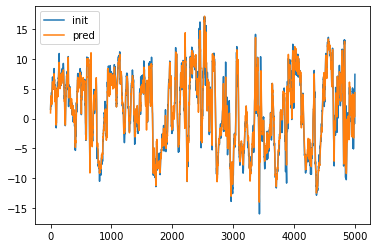

In [47]:
n = 2
plt.plot(b[5000:10000,n],label='init')
plt.plot(pred_x_ERA5.reshape(-1,50)[5000:10000,n],label='pred')
plt.legend()

In [48]:
cal_RMSE(a.values[:,0],pred_x_ERA5.reshape(len(pred_x_ERA5),-1)[:,0])

0.830765470144428

Test results:  
output: 5, train loss: 1.8007  
output: 6, train loss: 1.6209  
output: 8, train loss: 2.0476  
ReLU output: 5, train loss: 0.6864  
ReLU output: 6, train loss: 0.6872  
Sigmoid output: 6, train loss: 2.2636  

#### Using autoencoder result as ERA5 train_condition 

In [115]:
condition_1 = autoencoder(train_data_ERA5)[0].detach().numpy()
train_condition, test_condition = condition_1[:6000], condition_1[6000:7200]

In [337]:
def build_model_ConditionLSTM_FS_1buoy(train, train_condition, n_past, n_future, FS_order):
    # ##################### define parameters #######################
    latent_dim_cond = 100
    latent_dim = 200 # LSTM hidden units
    dropout = .20 
    verbose, epochs, batch_size = 0, 25, 16
    
    # ###################### prepare data ########################
    train_x, train_y = split_series(train.values, n_past, n_future)
    train_x = train_x[:,:,FS_order]
    train_y = train_y[:,:,target_feature]

    cond_1_train_temp = train_condition[n_past:-n_future+1]
    cond_1_train = cond_1_train_temp.reshape(cond_1_train_temp.shape[0], 1, -1)

    n_features_input = train_x.shape[2] # i.e. FS_order
    n_features_output = train_y.shape[2] # i.e. target_feature
    
    # ####################### Condition from ERA5 ##########################
    condition_inputs = Input(shape=(cond_1_train.shape[1], cond_1_train.shape[2])) 
    condition = LSTM(cond_1_train.shape[2], return_state=True)
    condition_states = condition(condition_inputs)[1:]
    
    # ####################### LSTM input from buoys ##########################
    encoder_inputs = Input(shape=(n_past, n_features_input))
    encoder_l1 = LSTM(latent_dim)(encoder_inputs)      #, return_state=True)
    decoder_l1 = RepeatVector(n_future)(encoder_l1)
    
    # ####################### Combine ERA5 condition & buoy measurement #########################
    decoder_lstm_2 = LSTM(cond_1_train.shape[2],return_sequences=True) #, dropout=dropout, return_sequences=True, return_state=True
    decoder_outputs3 = decoder_lstm_2(decoder_l1, initial_state=condition_states) #, initial_state=condition_states

    decoder_output1 = TimeDistributed(tf.keras.layers.Dense(100))(decoder_outputs3) #decoder_outputs2
    decoder_outputs2 = TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_output1)
    
    model = Model([condition_inputs, encoder_inputs], decoder_outputs2)
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
    model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
    # ###################### fit network #########################
    history = model.fit(x = [cond_1_train, train_x], y=train_y, epochs=epochs, batch_size=batch_size, 
                        verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)
    
    return model, history

In [338]:
model, history = build_model_ConditionLSTM_FS_1buoy(train, train_condition, n_past, n_future, FS_order)

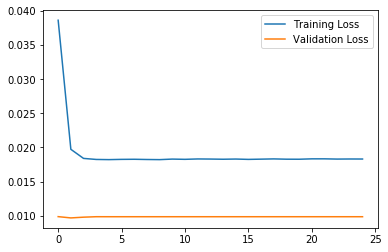

(0.018284482508897783, 0.009860514663159847)

In [231]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
np.mean(history.history['loss'][10:]), np.mean(history.history['val_loss'][10:])

In [188]:
condition_inputs, encoder_inputs, decoder_outputs2

(<KerasTensor: shape=(None, 1, 5) dtype=float32 (created by layer 'input_106')>,
 <KerasTensor: shape=(None, 24, 2) dtype=float32 (created by layer 'input_107')>,
 <KerasTensor: shape=(None, 12, 1) dtype=float32 (created by layer 'time_distributed_39')>)

In [191]:
cond_1_train.shape, train_x.shape, train_y.shape

((5965, 1, 5), (5965, 24, 2), (5965, 12, 1))

In [218]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.09 ** x)
#     model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
model.compile(loss='mse', optimizer='adam') # learning_rate=1e-3, decay_rate=0.9
#     # fit network
history = model.fit(x = [cond_1_train, train_x], y=train_y, epochs=epochs, batch_size=batch_size, 
                    verbose=verbose, callbacks=[reduce_lr], validation_split=0.2)

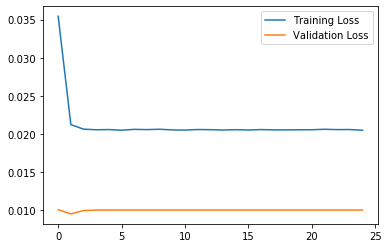

In [219]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [220]:
np.mean(history.history['loss'][10:]), np.mean(history.history['val_loss'][10:])

(0.020559958244363467, 0.010037564672529697)

In [232]:
test_condition_temp = test_condition[n_past:-n_future+1]
condition_test = test_condition_temp.reshape(test_condition_temp.shape[0],1, -1)

In [233]:
X_test.shape, condition_test.shape

((1129, 48, 21), (1129, 1, 5))

In [234]:
# Scaler results
y_test_1 = y_test.copy()
prd_LSTM_FS_1buoy = model.predict([condition_test, X_test[:,:,FS_order]])

In [235]:
for target_order in range(len(target_feature)):
    prd_LSTM_FS_1buoy[:,:,target_order]=scalers['scaler_'+table.columns[target_feature[target_order]]].inverse_transform(prd_LSTM_FS_1buoy[:,:,target_order])
    
y_test_1[:,:,target_feature_FS] = scalers['scaler_'+table.columns[target_feature_FS]].inverse_transform(y_test_1[:,:,target_feature_FS])

In [236]:
evaluate_forecasts(y_test_1[:,:,target_feature], prd_LSTM_FS_1buoy[:,:,0])

(array([0.2618799]),
 [0.2628991966523657,
  0.1777964581985682,
  0.1863562147994323,
  0.1930615268200569,
  0.19848066413337828,
  0.20443751191798,
  0.21060608169077646,
  0.21707096565447428,
  0.22418968644958315,
  0.2314749120811979,
  0.23933305924663859,
  0.2476453199965483,
  0.2560106649565428,
  0.26423424195720296,
  0.2724163625715598,
  0.28057825884653986,
  0.28864521442471935,
  0.29652787742836845,
  0.3039912490755014,
  0.3110345703456406,
  0.3177396951129615,
  0.324171845756341,
  0.33077994197243327,
  0.33756119361722114])

In [240]:
y_test_1[:,:,target_feature_FS]

array([[1.285, 1.41 , 1.44 , ..., 0.265, 0.36 , 0.385],
       [1.41 , 1.44 , 1.305, ..., 0.36 , 0.385, 0.335],
       [1.44 , 1.305, 1.145, ..., 0.385, 0.335, 0.31 ],
       ...,
       [0.62 , 0.65 , 0.73 , ..., 1.315, 1.47 , 1.535],
       [0.65 , 0.73 , 0.78 , ..., 1.47 , 1.535, 1.71 ],
       [0.73 , 0.78 , 0.775, ..., 1.535, 1.71 , 1.745]])

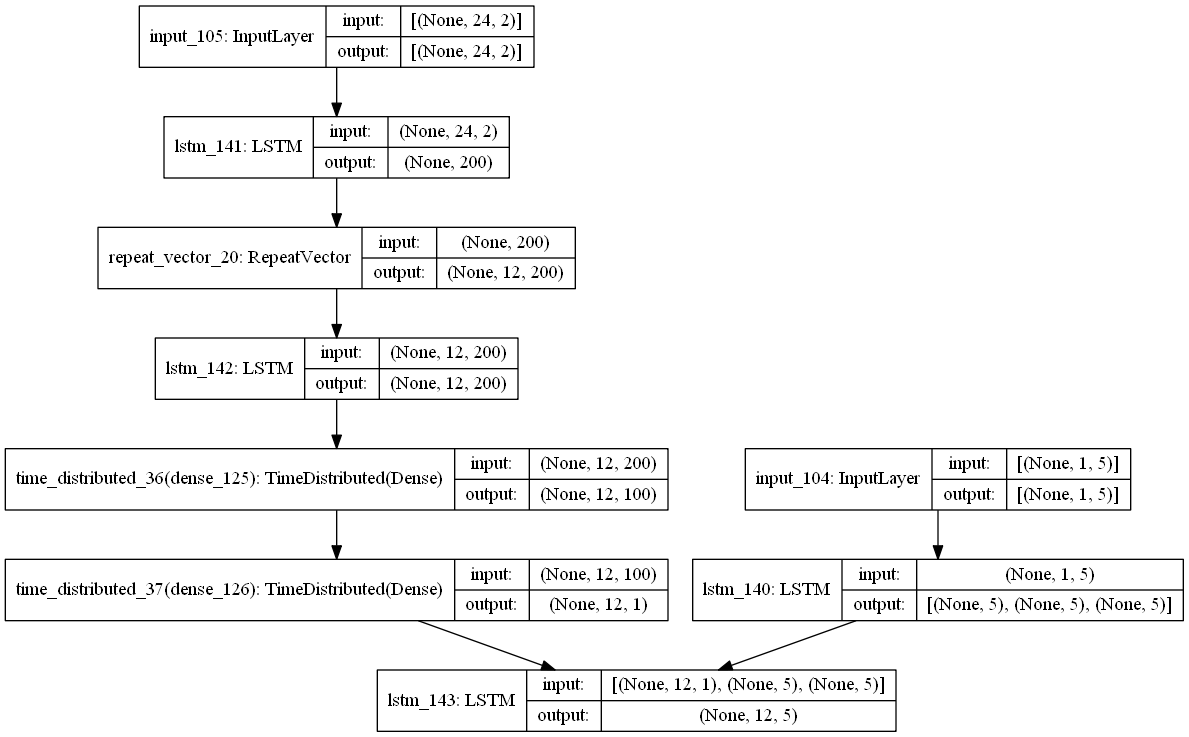

In [185]:
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

latent_dim_cond = 100
latent_dim = 200 # LSTM hidden units
dropout = .20 

train_x, train_y = split_series(train.values, n_past, n_future)
train_x = train_x[:,:,FS_order]
train_y = train_y[:,:,target_feature]
    
cond_1_train_temp = train_condition[n_past:-n_future+1]
cond_1_train = cond_1_train_temp.reshape(cond_1_train_temp.shape[0], 1, -1)
    
    # define parameters
verbose, epochs, batch_size = 0, 25, 16
n_features_input = train_x.shape[2] # i.e. FS_order
n_features_output = train_y.shape[2] # i.e. target_feature

######################## Condition ##########################
# Define an input series and encode it with an LSTM. 
condition_inputs = Input(shape=(cond_1_train.shape[1], cond_1_train.shape[2])) 
condition = LSTM(cond_1_train.shape[2], return_state=True)
condition_states = condition(condition_inputs)[1:]

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.

######################## Condition ##########################

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

######################## TS ##########################
encoder_inputs = Input(shape=(n_past, n_features_input))
encoder_l1 = LSTM(latent_dim)(encoder_inputs)      #, return_state=True)
decoder_l1 = RepeatVector(n_future)(encoder_l1)
decoder_l1 = LSTM(latent_dim, return_sequences=True)(decoder_l1)


######################### encoder_inputs, decoder_outputs1 ############################
######################## TS ##########################

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
# decoder_lstm_1 = LSTM(latent_dim_cond, dropout=dropout, return_state=True)
# decoder_outputs_1, _, _ = decoder_lstm_1(decoder_inputs)


decoder_output1 = TimeDistributed(tf.keras.layers.Dense(100))(decoder_l1) #decoder_outputs2
decoder_outputs2 = TimeDistributed(tf.keras.layers.Dense(n_features_output))(decoder_output1)

decoder_lstm_2 = LSTM(cond_1_train.shape[2], dropout=dropout, return_sequences=True) #, dropout=dropout, return_sequences=True, return_state=True
decoder_outputs3 = decoder_lstm_2(decoder_outputs2, initial_state=condition_states) #, initial_state=condition_states

# decoder_dense = Dense(100) # 1 continuous output at each timestep
# decoder_outputs = decoder_dense(decoder_outputs)
# TimeDistributed(Dense(100, activation='relu'))

# attn_layer = Attention()([encoder_outputs, decoder_outputs])
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([condition_inputs, encoder_inputs], decoder_outputs3)
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs1)
# print(model.summary())

plot_model(model, show_shapes=True, show_layer_names=True)

# 6) Evaluate prediction

In [212]:
from sklearn.metrics import mean_squared_error
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
            # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [213]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [354]:
# build_model_LSTM_1_1buoy(train, n_past, n_future, FS_order)
# build_model_LSTM_1buoy(train, n_past, n_future, FS_order)

model, history = build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order) # For most taget variable

# model, history = build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order) 
# model, history = build_model_2StackedLSTM(train, n_past, n_future, FS_order)
# 
# model, history = build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order) # For Dirp

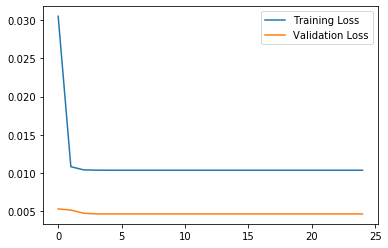

In [49]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [50]:
np.mean(history.history['loss'][10:]), np.mean(history.history['val_loss'][10:])

(0.010375834194322427, 0.00467603700235486)

In [51]:
# Scaler results
y_test_1 = y_test.copy()
prd_LSTM_FS_1buoy = model.predict(X_test[:,:,FS_order])

In [52]:
# Reverse to original data
for target_order in range(len(target_feature)):
    prd_LSTM_FS_1buoy[:,:,target_order]=scalers['scaler_'+table.columns[target_feature[target_order]]].inverse_transform(prd_LSTM_FS_1buoy[:,:,target_order])
    
y_test_1[:,:,target_feature_FS] = scalers['scaler_'+table.columns[target_feature_FS]].inverse_transform(y_test_1[:,:,target_feature_FS])

Evaluate forecast of variables other than Dirp

In [2137]:
evaluate_forecasts(y_test_1[:,:,target_feature], prd_LSTM_FS_1buoy[:,:,0])

(array([0.10224263]),
 [0.047498607421866984,
  0.05171658952379824,
  0.06522091007628801,
  0.0771278802493506,
  0.08655944600550654,
  0.09558931237224963,
  0.10445272079675703,
  0.11297851104829879,
  0.12097718142596371,
  0.12861661907043595,
  0.13587734117337918,
  0.1427050188197363])

Evaluate forecast of Dirp

In [1916]:
# Reverse to original data
# for target_order in range(len(target_feature)):
#     y_test_1[:,:,target_feature[target_order]] = scalers['scaler_'+table.columns[target_feature[target_order]]].inverse_transform(y_test_1[:,:,target_feature[target_order]])


In [2009]:
target_feature_FS

18

In [2040]:
sinx = prd_LSTM_FS_1buoy[:,:,0].flatten()
cosx = prd_LSTM_FS_1buoy[:,:,1].flatten()

In [2052]:
Dirp1_reverse = np.array([return_degree(sinx[j],cosx[j]) for j in range(len(sinx))])
b = Dirp1_reverse.reshape(prd_LSTM_FS_1buoy[:,:,0].shape[0],prd_LSTM_FS_1buoy[:,:,0].shape[1])
b.shape

(1165, 12)

In [2053]:
a = y_test_1[:,:,target_feature_FS]
a.shape
# a[np.isnan(a)]

(1165, 12)

In [2054]:
# step = 1
for step in range(12):
#     print('Step_'+str(step+1),mean_absolute_error(a[:,step,:][~np.isnan(b[:,step,:])], b[:,step,:][~np.isnan(b[:,step,:])]))
    print('Step_'+str(step+1),cal_RMSE(a[:,step][~np.isnan(b[:,step])], b[:,step][~np.isnan(b[:,step])]))

Step_1 66.49433745963286
Step_2 18.88588262897387
Step_3 20.10987529734632
Step_4 22.773306215246304
Step_5 25.590622794986004
Step_6 25.240416624826835
Step_7 26.08481829578878
Step_8 25.652945507967953
Step_9 24.416237639660853
Step_10 23.956776028971838
Step_11 23.063652291849376
Step_12 23.398450942557762


In [2055]:
evaluate_forecasts(a, b)

(29.694490712697323,
 [66.49433745963286,
  18.88588262897387,
  20.10987529734632,
  22.773306215246304,
  25.590622794986004,
  25.240416624826835,
  26.08481829578878,
  25.652945507967953,
  24.416237639660853,
  23.956776028971838,
  23.063652291849376,
  23.398450942557762])

In [1959]:
evaluate_forecasts(a, b)

(18.506226670923382,
 [17.25219920816222,
  15.676021352179324,
  16.320339832161316,
  17.13469419750185,
  17.841872964473666,
  18.48098558084695,
  18.948753475159528,
  19.364806370084054,
  19.678476813802952,
  19.99088995243125,
  20.19265741517277,
  20.442261604202915])

Dir end

In [53]:
evaluate_forecasts(y_test_1[:,:,target_feature], 
                   prd_LSTM_FS_1buoy[:,:,0])

(array([0.197064]),
 [0.0852796650680102,
  0.10747161113109353,
  0.13167894230933477,
  0.15327145182127797,
  0.17210257979764593,
  0.18842242942753099,
  0.2028851898637386,
  0.2162718370848196,
  0.229704977481448,
  0.2434158631015869,
  0.2580763878756226,
  0.27327473621425125])

In [54]:
from sklearn.metrics import mean_absolute_error
# for index,i in enumerate(train_df.columns[:7]):
#     print(i)
for j in range(1,n_future+1):
    print("LSTM half hr ",j,":","MAE: ",mean_absolute_error(y_test[:,j-1,target_feature],prd_LSTM_FS_1buoy[:,j-1,target_feature]),end=", ")
    print("LSTM half hr ",j,":","RMSE: ",cal_RMSE(y_test_1[:,j-1,target_feature],prd_LSTM_FS_1buoy[:,j-1,target_feature]),end=", ")
    print()


LSTM half hr  1 : MAE:  1.3534207985711966, LSTM half hr  1 : RMSE:  0.0852796650680102, 
LSTM half hr  2 : MAE:  1.3500684999302972, LSTM half hr  2 : RMSE:  0.10747161113109353, 
LSTM half hr  3 : MAE:  1.3633677072427948, LSTM half hr  3 : RMSE:  0.13167894230933477, 
LSTM half hr  4 : MAE:  1.3653001219572578, LSTM half hr  4 : RMSE:  0.15327145182127797, 
LSTM half hr  5 : MAE:  1.3634808710952142, LSTM half hr  5 : RMSE:  0.17210257979764593, 
LSTM half hr  6 : MAE:  1.3635851789909317, LSTM half hr  6 : RMSE:  0.18842242942753099, 
LSTM half hr  7 : MAE:  1.3640031951828056, LSTM half hr  7 : RMSE:  0.2028851898637386, 
LSTM half hr  8 : MAE:  1.3643264533149166, LSTM half hr  8 : RMSE:  0.2162718370848196, 
LSTM half hr  9 : MAE:  1.3639002752229528, LSTM half hr  9 : RMSE:  0.229704977481448, 
LSTM half hr  10 : MAE:  1.362794278526399, LSTM half hr  10 : RMSE:  0.2434158631015869, 
LSTM half hr  11 : MAE:  1.3611935124374026, LSTM half hr  11 : RMSE:  0.2580763878756226, 
LST

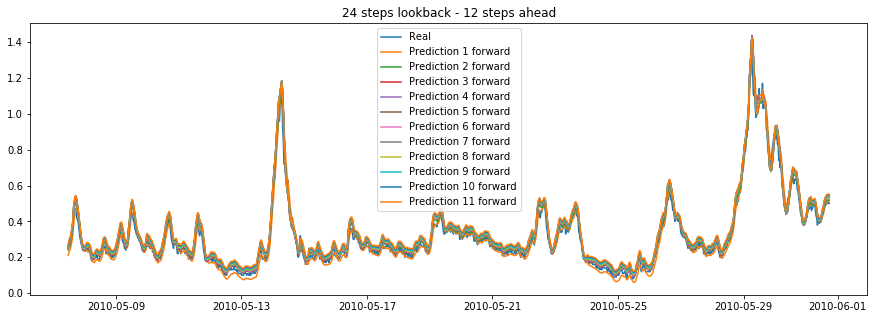

In [2227]:
plt.figure(figsize=(15,5))
plt.title('24 steps lookback - 12 steps ahead')

plt.plot(test_df.index[24-1:len(test_df)-12], test_df.iloc[24-1:len(test_df)-12,target_feature_FS],label='Real')
for i in range(1,n_future):
#     plt.subplot(6,1,i)
    
    plt.plot(test_df.index[24-1:len(test_df)-12], prd_LSTM_FS_1buoy[:,i-1,0], label='Prediction '+ str(i) + ' forward')
    plt.legend()
#     print(str(i)+' lookback RMSE: ',cal_RMSE(predict[:,i-1,0],test[12+i-1:len(test)-5+i-1,0]), 'R2: ',r2_score(predict[:,i-1,0],test[12+i-1:len(test)-5+i-1,0], multioutput='raw_values'))

    # plt.ylim(0,5)
plt.savefig('24-12_LSTM_1Hs.png',box_inches='tight')

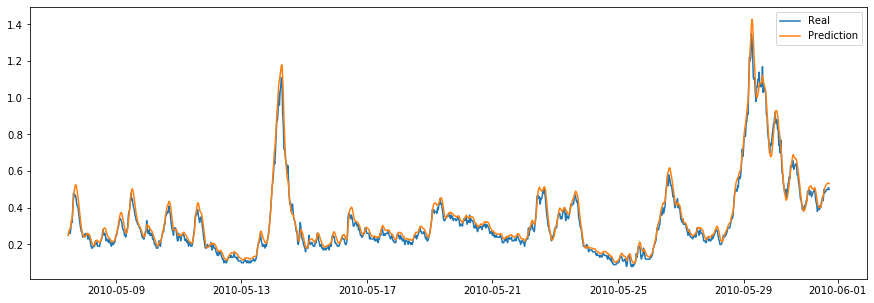

In [2229]:
i = 6 # future
plt.figure(figsize=(15,5))
# plt.plot(test.index[24+i-1:], y_test_1[:, 11,target_feature[0]],label='Real')
plt.plot(test_df.index[24-1:len(test)-12], test_df.iloc[24-1:len(test)-12,target_feature_FS],label='Real')
plt.plot(test_df.index[24-1:len(test)-12], prd_LSTM_FS_1buoy[:,i-1,0],label='Prediction')
plt.legend()

# Model Plot

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 200)               162400    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 12, 200)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 12, 100)           20100     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 12, 1)             101       
Total params: 503,401
Trainable params: 503,401
Non-trainable params: 0
_________________________________________________________________
None


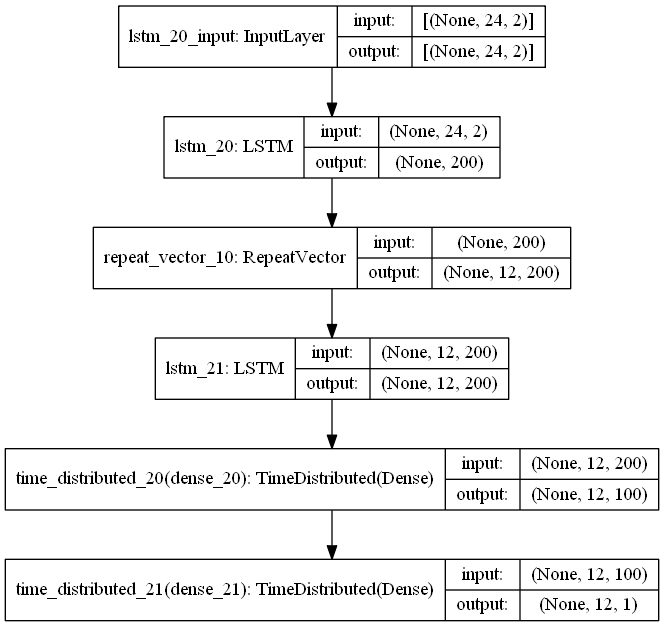

In [1472]:
model = build_model_LSTM_FS_1buoy(train, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True) # to_file=

In [1476]:
model = build_model_LSTM_FS_Dirp(train, n_past, n_future, FS_order)
print(model.summary())
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 200)               162400    
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 12, 200)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 12, 200)           320800    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 12, 100)           20100     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 12, 2)             202       
Total params: 503,502
Trainable params: 503,502
Non-trainable params: 0
_________________________________________________________________
None


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 24, 7)]      0                                            
__________________________________________________________________________________________________
lstm_88 (LSTM)                  [(None, 200), (None, 166400      input_32[0][0]                   
__________________________________________________________________________________________________
repeat_vector_41 (RepeatVector) (None, 12, 200)      0           lstm_88[0][0]                    
__________________________________________________________________________________________________
lstm_89 (LSTM)                  (None, 12, 200)      320800      repeat_vector_41[0][0]           
                                                                 lstm_88[0][1]             

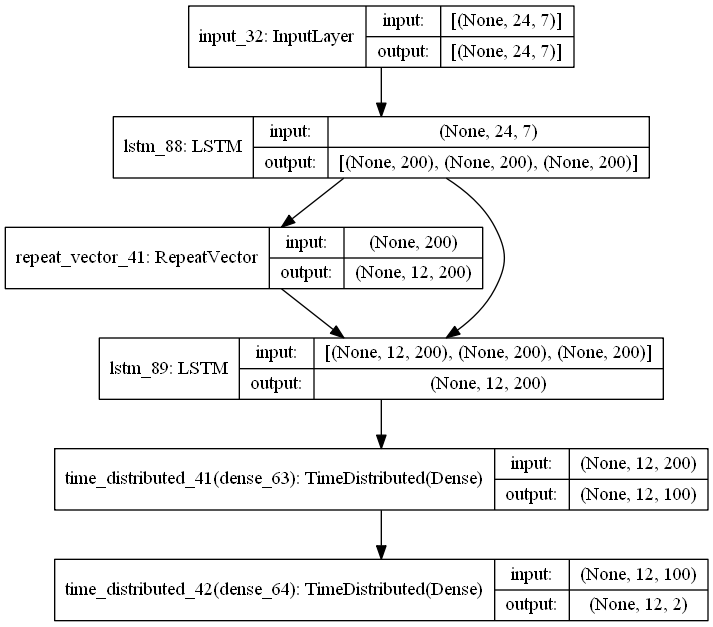

In [1991]:
model = build_model_StackedLSTM_FS_1buoy(train, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True) # to_file=

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 24, 7)]      0                                            
__________________________________________________________________________________________________
lstm_96 (LSTM)                  [(None, 24, 200), (N 166400      input_35[0][0]                   
__________________________________________________________________________________________________
lstm_97 (LSTM)                  [(None, 200), (None, 320800      lstm_96[0][0]                    
__________________________________________________________________________________________________
repeat_vector_44 (RepeatVector) (None, 12, 200)      0           lstm_97[0][0]                    
___________________________________________________________________________________________

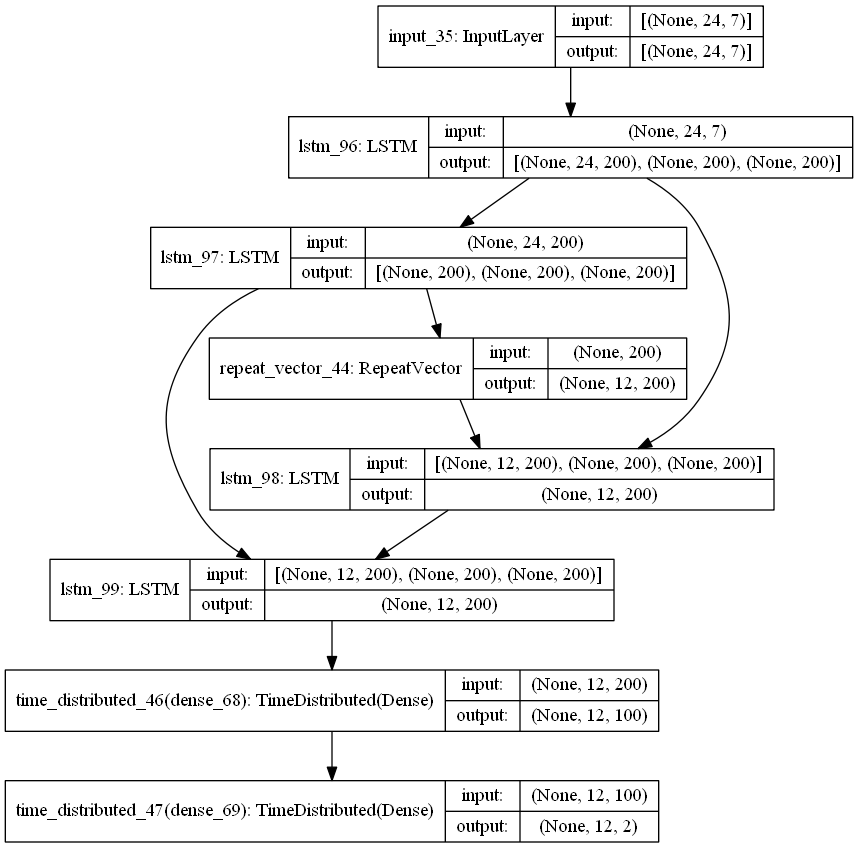

In [1996]:
model = build_model_2StackedLSTM(train, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True) # to_file=

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_131 (InputLayer)          [(None, 24, 2)]      0                                            
__________________________________________________________________________________________________
lstm_179 (LSTM)                 (None, 200)          162400      input_131[0][0]                  
__________________________________________________________________________________________________
input_130 (InputLayer)          [(None, 1, 5)]       0                                            
__________________________________________________________________________________________________
repeat_vector_33 (RepeatVector) (None, 12, 200)      0           lstm_179[0][0]                   
___________________________________________________________________________________________

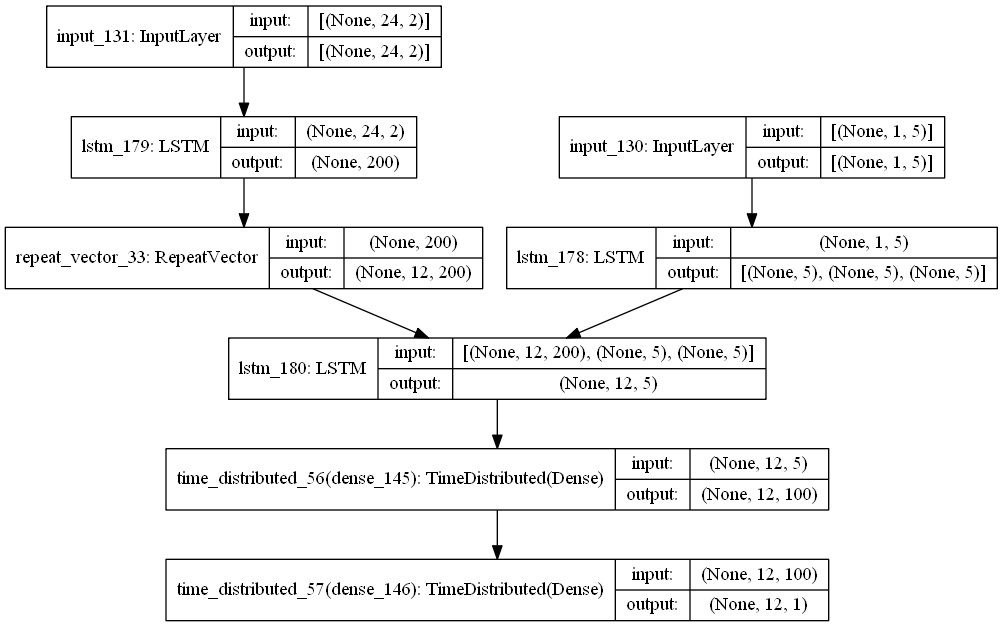

In [356]:
model, history = build_model_ConditionLSTM_FS_1buoy(train, train_condition, n_past, n_future, FS_order)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Decomposition of time series

<!-- # Multivariate Multi-step Time Series - End
Stacked LSTM Seq2Seq Autoencoder in Tensorflow 2.0/Keras
code from the following
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/ -->

In [357]:
table

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,2Peak Direction (degrees),2Spread (degrees),2Sea Temp (C),3Wave Height (m),3Max Wave Height (m),3Tpeak (s),3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C)
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.390,0.560,10.80,6.55,187.5,13.0,8.15,0.550,0.780,12.20,...,204.5,17.0,9.05,0.530,0.865,7.65,4.05,299.5,34.5,9.05
2010-01-02 01:00:00,0.380,0.570,12.15,6.90,184.0,10.5,8.15,0.515,0.825,11.80,...,209.0,16.5,9.00,0.545,0.770,7.20,4.15,303.0,40.0,9.00
2010-01-02 02:00:00,0.370,0.525,10.80,7.10,189.0,12.0,8.30,0.465,0.690,11.50,...,212.0,16.5,9.00,0.590,0.950,10.25,4.20,280.0,27.0,8.85
2010-01-02 03:00:00,0.350,0.555,11.10,5.75,190.0,20.5,8.85,0.480,0.780,10.80,...,219.0,13.5,8.95,0.705,1.260,4.40,3.75,332.0,44.0,8.80
2010-01-02 04:00:00,0.360,0.550,10.50,6.90,187.0,25.0,8.90,0.480,0.720,10.55,...,216.0,17.0,8.50,0.840,1.375,4.60,3.50,337.5,47.0,9.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,0.850,1.495,5.05,4.30,188.0,20.5,10.60,0.880,1.375,11.15,...,210.5,15.0,10.70,1.460,2.230,11.80,6.40,266.0,48.5,10.60
2019-12-30 20:00:00,0.805,1.145,5.15,4.35,188.0,18.5,10.60,0.920,1.285,10.80,...,212.5,12.5,10.70,1.425,2.070,11.45,6.65,260.5,41.5,10.60
2019-12-30 21:00:00,0.745,1.225,5.15,4.30,185.0,19.0,10.55,0.905,1.165,10.55,...,206.0,14.0,10.85,1.280,2.020,11.80,6.45,282.0,36.0,10.60


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


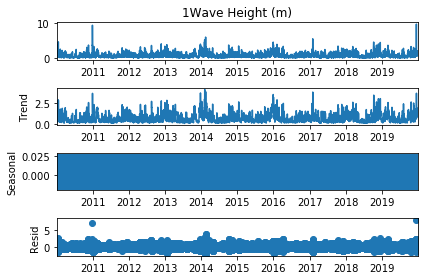

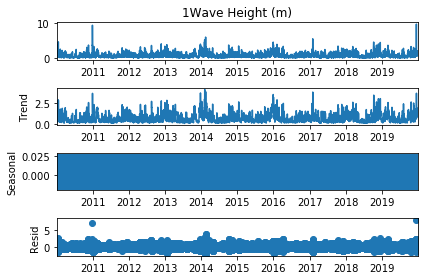

In [359]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(table.dropna(axis=0)['1Wave Height (m)'], freq=24, two_sided=False)
decomposition.plot()

In [360]:
from sklearn.metrics import r2_score

In [361]:
table.resample('h').mean().dropna(axis=0)

,1Wave Height (m),1Max Wave Height (m),1Tpeak (s),1Tz (s),1Peak Direction (degrees),1Spread (degrees),1Sea Temp (C),2Wave Height (m),2Max Wave Height (m),2Tpeak (s),...,2Peak Direction (degrees),2Spread (degrees),2Sea Temp (C),3Wave Height (m),3Max Wave Height (m),3Tpeak (s),3Tz (s),3Peak Direction (degrees),3Spread (degrees),3Sea Temp (C)
Time (GMT),,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.390,0.560,10.80,6.55,187.5,13.0,8.15,0.550,0.780,12.20,...,204.5,17.0,9.05,0.530,0.865,7.65,4.05,299.5,34.5,9.05
2010-01-02 01:00:00,0.380,0.570,12.15,6.90,184.0,10.5,8.15,0.515,0.825,11.80,...,209.0,16.5,9.00,0.545,0.770,7.20,4.15,303.0,40.0,9.00
2010-01-02 02:00:00,0.370,0.525,10.80,7.10,189.0,12.0,8.30,0.465,0.690,11.50,...,212.0,16.5,9.00,0.590,0.950,10.25,4.20,280.0,27.0,8.85
2010-01-02 03:00:00,0.350,0.555,11.10,5.75,190.0,20.5,8.85,0.480,0.780,10.80,...,219.0,13.5,8.95,0.705,1.260,4.40,3.75,332.0,44.0,8.80
2010-01-02 04:00:00,0.360,0.550,10.50,6.90,187.0,25.0,8.90,0.480,0.720,10.55,...,216.0,17.0,8.50,0.840,1.375,4.60,3.50,337.5,47.0,9.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,0.850,1.495,5.05,4.30,188.0,20.5,10.60,0.880,1.375,11.15,...,210.5,15.0,10.70,1.460,2.230,11.80,6.40,266.0,48.5,10.60
2019-12-30 20:00:00,0.805,1.145,5.15,4.35,188.0,18.5,10.60,0.920,1.285,10.80,...,212.5,12.5,10.70,1.425,2.070,11.45,6.65,260.5,41.5,10.60
2019-12-30 21:00:00,0.745,1.225,5.15,4.30,185.0,19.0,10.55,0.905,1.165,10.55,...,206.0,14.0,10.85,1.280,2.020,11.80,6.45,282.0,36.0,10.60


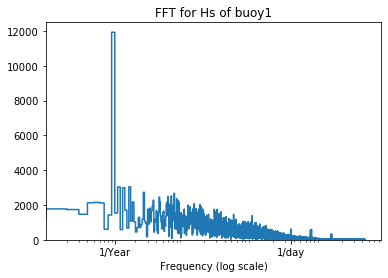

In [380]:
import tensorflow as tf

Hs = table.dropna(axis=0)['1Wave Height (m)']
fft = tf.signal.rfft(Hs)
f_per_dataset = np.arange(0, fft.shape.as_list()[0])

n_samples_h = len(Hs)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 12500)
plt.xlim([0.1, max(plt.xlim())])
plt.title('FFT for Hs of buoy1')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
# plt.savefig('FFT_sat_windspeed_stationA.pdf')